In [72]:
### Ligand Database ###
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd
from copy import deepcopy
from rdkit import Chem
from SBLMDCOVDOCK.SBLSettings import DOCKING_Settings
import numpy as np
settings = DOCKING_Settings()
import ast
from sklearn.manifold import TSNE
import plotly.express as px
from phate import PHATE

from sklearn.decomposition import PCA
import numpy as np


In [2]:
url =  "http://bldb.eu/S-BLDB.php"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find_all('table')  # Replace 'table' with the appropriate HTML element or attributes


In [3]:
df = pd.read_html(str(table))[1]
# drop the first row
df.drop(df.index[0], inplace=True)

# fill empty cells in Ligands with APO
df['Ligands'] = df['Ligands'].fillna('APO')
df.Ligands = df.Ligands.apply(lambda x: x.split(" "))

# drop Ambler class B-3
df = df[df['Ambler class'] != 'B1']
df = df[df['Ambler class'] != 'B2']
df = df[df['Ambler class'] != 'B3']
df.head()



Ambler class Protein name PDB code Resolution (Å) Release date UniProt code  \
1            A       BAA-33     6NI1           1.90   2019-01-30   A0A1Y0WMN3   
2            A       BAA-83     6W2Z           1.50   2020-03-25       P39824   
3            A        BEL-1     4MX4           1.60   2014-10-01       Q3SAW3   
4            A        BEL-1     4MXB           1.79   2014-10-01       Q3SAW3   
5            A        BEL-1     4MXG           1.48   2014-10-01       Q3SAW3   

  PubMed ID  DOI  PDB Mutations                   Ligands Space group  \
1       NaN  NaN  pdb       NaN                [EDO, FMT]        P 65   
2       NaN  NaN  pdb       NaN          [*NXL, EDO, FMT]    P 1 21 1   
3       NaN  NaN  pdb       NaN  [CL, EDO, FLC, IPA, PGE]   P 21 21 2   
4       NaN  NaN  pdb       NaN                [*IM2, CL]    P 1 21 1   
5       NaN  NaN  pdb       NaN            [CL, FLC, MPD]    P 1 21 1   

                         Unit cell parameters  Z value  
1  87.849 87.849 149.853 ♦ 90.00 90.00 120.00     12.0  
2    39.681 85.456 70.360 ♦ 90.00 94.97 90.00      4.0  
3  100.270 120.920 53.410 ♦ 90.00 90.00 90.00      8.0  
4   53.980 95.860 103.420 ♦ 90.00 91.97 90.00      8.0  
5   54.840 94.690 103.680 ♦ 90.00 92.64 90.00      8.0

In [4]:
for CLASS in df['Ambler class'].unique():
    print(CLASS)

A
C
D


In [5]:
df["Covalent"] = df.Ligands.apply(lambda x: [y for y in x if "*" in y])
df["Covalent"] = df.Covalent.apply(lambda x: x[0] if len(x) > 0 else None)
df["Covalent"] = df.Covalent.apply(lambda x: x.strip("*") if x is not None else None)

df["Michaelis"] = df.Ligands.apply(lambda x: [y for y in x if "$" in y])
df["Michaelis"] = df.Michaelis.apply(lambda x: x[0] if len(x) > 0 else None)    
df["Michaelis"] = df.Michaelis.apply(lambda x: x.strip("$") if x is not None else None)

df["APO"] = df.Ligands.apply(lambda x: "APO" if (("*" or "#" or "$") not in "".join(x)) else None)
df.Ligands = df.Ligands.apply(lambda x: "APO" if (("*" or "#" or "$") not in "".join(x)) else x)
df.Ligands = df.Ligands.apply(lambda x: [y for y in x if (("*" or "#" or "$") in y)])
df.Ligands = df.Ligands.apply(lambda x: ["APO"] if len(x) == 0 else x)


single_ligand = df[df.Ligands.apply(lambda x: len(x) == 1)]

# convert ligands to string
single_ligand.Ligands = single_ligand.Ligands.apply(lambda x: x[0])
# print(single_ligand.head())
# remove APO
single_ligand = single_ligand[single_ligand.Ligands != "APO"]
print(single_ligand.head())



   Ambler class Protein name PDB code Resolution (Å) Release date  \
2             A       BAA-83     6W2Z           1.50   2020-03-25   
4             A        BEL-1     4MXB           1.79   2014-10-01   
9             A        BEL-1     5EPH           1.79   2016-09-21   
10            A        BEL-1     5EUA           1.85   2016-09-21   
12            A      BcI-248     6W33           1.85   2020-03-25   

   UniProt code PubMed ID                   DOI  PDB Mutations Ligands  \
2        P39824       NaN                   NaN  pdb       NaN    *NXL   
4        Q3SAW3       NaN                   NaN  pdb       NaN    *IM2   
9        Q3SAW3  27671060  10.1128/AAC.00936-16  pdb       NaN    *ID1   
10       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb       NaN    *3P7   
12   A0A5B7VP54       NaN                   NaN  pdb       NaN    *1X6   

   Space group                       Unit cell parameters  Z value Covalent  \
2     P 1 21 1   39.681 85.456 70.360 ♦ 90.00 94.97 90.00    

/var/folders/4c/64jkr7n54w1558kqk0ks5rgr0000gn/T/ipykernel_25523/3996476523.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_ligand.Ligands = single_ligand.Ligands.apply(lambda x: x[0])


In [6]:
print(df.Covalent.value_counts())

Covalent
NXL    47
IM2    17
MER    16
CB4    12
CAZ    12
       ..
0RJ     1
2AW     1
1OG     1
17O     1
H9O     1
Name: count, Length: 209, dtype: int64


In [7]:
for lig in single_ligand.Ligands:
    print(lig)

*NXL
*IM2
*ID1
*3P7
*1X6
*ISS
*DWZ
*DRW
*1RG
*2RG
*XD1
*AXL
*AIX
*CB9
*XD2
*DXF
*DH4
*NFF
*9EP
*7EP
*CD8
*CD6
*NXL
*SFR
*AXL
*PCZ
*TEB
*33V
*3Y6
*FZS
*FZS
*FZS
*FZS
*ISS
*FK2
*NXL
*TBE
*TSL
*TSL
*TSL
*TSL
*TSL
*TSL
*TSL
*CB4
*CB4
*CB4
*CB4
*CB4
*SM2
*NBF
*CFX
*2GK
*CB4
*CB4
*CAZ
*CAZ
*8CY
*NXL
*NXL
*NXL
*TJ7
*4D6
*CAZ
*CAZ
*CAZ
*X57
*TDJ
*CEF
*AIX
*BO2
*6V8
*NXL
*NXL
*4D6
*5VR
*5VW
*602
*C6S
*MK7
*KJK
*QBZ
*TVE
*TVE
*ZXQ
*LBX
*LD0
*NW3
*CEF
*CEP
*PNM
*CEO
*PCZ
*AZR
*CAZ
*BZB
*BZB
*BZB
*OP0
*AZR
*PNM
*TSL
*TSL
*ISS
*ISS
*PCZ
*PCZ
*AZR
*NXL
*IM2
*TBE
*1RG
*IM2
*IM2
*HD5
*SR3
*NPB
*NXL
*ZXM
*6YV
*6YV
*C8Y
*C8Y
*C8V
*C8V
*C9D
*CD7
*BHU
*BX6
*BX9
*BXU
*MK7
*4D6
*KJK
*RM9
*4D6
*CEF
*CAZ
*R0B
*J00
*IM2
*4D6
*ZXQ
*OC0
*7TC
*AIX
*CEO
*O2F
*N9X
*MK7
*MK7
*CAZ
*OK3
*NXL
*MK7
*AP3
*FOS
*CED
*PNM
*NXL
*CFX
*PNM
*PCZ
*CED
*PCZ
*CED
*DWZ
*CED
*CED
*CED
*CED
*BIY
*L4C
*1X6
*TBE
*NXL
*IM2
*SFR
*MER
*MER
*MER
*WY4
*WY2
*TBI
*TBE
*TSL
*TEM
*TEM
*TSL
*TBE
*SA2
*MER
*LN1
*CB4
*CZ7
*CZ8
*CZ9
*SA2
*SA2
*SA2


In [8]:

for idx, lig in enumerate(df.Ligands):
    #
    if len(lig) > 1:

        print(lig)
        # for jdx, ligand in enumerate(lig):





['*3P7', '*MOX']
['*CUG', '*FZS']
['*HIW', '*ID1']
['*CEM', '*TEM']
['*AKR', '*TBE']
['*L4A', '*TEM']
['*OX6', '*OX7']
['*HIW', '*ID1']
['*4J6', '*DRW']


In [9]:
# strip * from Ligand entries
single_ligand.Ligands = single_ligand.Ligands.apply(lambda x: x.strip('*'))


In [10]:
# drop duplicate entries in Ligands, keep first
unique_ligands = single_ligand.drop_duplicates(subset=['Ligands'], keep='first')
unique_ligands.Ligands

2       NXL
4       IM2
9       ID1
10      3P7
12      1X6
       ... 
1509    4J6
1512    DGF
1518    CTJ
1525    QS8
1529    H9O
Name: Ligands, Length: 203, dtype: object

In [12]:
def download_ligands(ligcode,settings=settings):
    """
    Download ligand sdf from PDB database
    """
    url = f"https://files.rcsb.org/ligands/download/{ligcode}_ideal.sdf"
    sdf_file = os.path.join(settings.structures_input, f"{ligcode}.sdf")

    response = requests.get(url)
    response.raise_for_status()  # Ensure we got a valid response

    # Write the content of the response to a file
    with open(sdf_file, 'wb') as f:
        f.write(response.content)

    print(f"Ligand {ligcode} downloaded at {sdf_file}")

In [13]:
for ligandcode in unique_ligands.Ligands:
    break
    download_ligands(ligandcode)

In [14]:
def SDF_to_SMILES(path):
    """
    Convert SDF file to SMILES file
    """
    suppl = Chem.SDMolSupplier(path)
    for mol in suppl:
        if mol is None: continue
        return Chem.MolToSmiles(mol)

In [15]:
# add smiles to unique_ligands
for ligandcode in unique_ligands.Ligands:
    path = os.path.join(settings.structures_input, ligandcode+".sdf")
    smiles = SDF_to_SMILES(path)
    print(ligandcode, smiles)
    unique_ligands.loc[unique_ligands.Ligands == ligandcode, "SMILES"] = smiles
    
    

NXL NC(=O)[C@@H]1CC[C@@H](NOS(=O)(=O)O)CN1C=O
IM2 C[C@@H](O)[C@@H](C=O)[C@H]1CC(SCCNC=N)=C(C(=O)O)N1
ID1 C[C@@H](O)[C@@H](C=O)[C@H]1C[C@@H](SCC/N=C\N)C(C(=O)O)=N1
3P7 C=C1CO[C@H]([C@@](C=O)(NC(=O)[C@H](C(=O)O)c2ccc(O)cc2)OC)N=C1C(=O)O
1X6 N/C=C/C(=O)OC[C@H](N)C(=O)O
ISS O=C/C=C/NCC(=O)CCO
DWZ C[C@@H]1[C@H]([C@H](C=O)[C@@H](C)O)N=C(C(=O)O)[C@H]1S[C@@H]1CN[C@H](C(=O)N(C)C)C1
DRW C[C@@H]1[C@H]([C@H](C=O)[C@@H](C)O)N=C(C(=O)O)[C@H]1S[C@@H]1CN[C@H](CNS(N)(=O)=O)C1
1RG C[C@@H](O)[C@@H](C=O)[C@@H]1NC(C(=O)O)=C(S[C@@H]2CN[C@H](C(=O)Nc3cccc(C(=O)O)c3)C2)[C@@H]1C
2RG C[C@@H]1[C@H]([C@H](C=O)[C@@H](C)O)N=C(C(=O)O)[C@H]1S[C@@H]1CN[C@H](C(=O)Nc2cccc(C(=O)O)c2)C1
XD1 CC1(C)S[C@H]([C@H](N)C=O)N[C@H]1C(=O)O
AXL CC1(C)S[C@H]([C@@H](C=O)NC(=O)[C@H](N)c2ccc(O)cc2)N[C@H]1C(=O)O
AIX CC1(C)S[C@H]([C@@H](C=O)NC(=O)[C@H](N)c2ccccc2)N[C@H]1C(=O)O
CB9 CC1(C)S[C@H]([C@@H](C=O)NC(=O)[C@@H](C(=O)O)c2ccccc2)N[C@H]1C(=O)O
XD2 Cn1nnnc1SCC1=C(C(=O)O)N[C@@H]([C@@H](C=O)NC(=O)[C@H](O)c2ccccc2)SC1
DXF CO/N=C(\C(=O)N[C@H]

/var/folders/4c/64jkr7n54w1558kqk0ks5rgr0000gn/T/ipykernel_25523/1632903031.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_ligands.loc[unique_ligands.Ligands == ligandcode, "SMILES"] = smiles
[17:20:34] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[17:20:34] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


In [16]:
print(unique_ligands.Ligands)

     Ambler class Protein name PDB code Resolution (Å) Release date  \
2               A       BAA-83     6W2Z           1.50   2020-03-25   
4               A        BEL-1     4MXB           1.79   2014-10-01   
9               A        BEL-1     5EPH           1.79   2016-09-21   
10              A        BEL-1     5EUA           1.85   2016-09-21   
12              A      BcI-248     6W33           1.85   2020-03-25   
...           ...          ...      ...            ...          ...   
1509            D       OXA-48     6P9C           1.90   2019-08-07   
1512            D       OXA-48     6PSG           2.13   2020-01-22   
1518            D       OXA-48     6Q5F           2.50   2019-03-20   
1525            D       OXA-48     6ZXI           1.85   2021-08-11   
1529            D       OXA-48     7DML           1.94   2021-12-15   

     UniProt code PubMed ID                       DOI  PDB Mutations Ligands  \
2          P39824       NaN                       NaN  pdb       Na

In [17]:
# Add scaffolds: DBO, β-Lactam,Cyclic boronate inhibitor, Non-β-lactam
# Add scaffold: DBO: 
dbo_smiles = "C1CN2CCN1CC2"
dbo_name = "DABCO"
dbo_warhead = "C1CNC(=O)N1" #Imidazolidone
dbo_warhead_name = "DBO_warhead"
# Add scaffold: β-Lactam
blactam_smiles = "C1CNC2CC1C2"
blactam_name = "bLAC"
blactam_warhead = "C1CNC1=O" #beta-lactam
blactam_warhead_name = "bLAC_warhead"

# Add scaffold: Cyclic boronate inhibitor: https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00911
cbi_smiles = "OB1Oc2c(ccc(F)c2C(O)=O)[C@H]2C[C@@H]12"
cbi_name = "QPX7728" #https://drug-discovery.vm.uni-freiburg.de/covpdb/complex_card/pdb_ligand_id=1959
cbi_warhead = "B(C)(O)O" #Boronate
cbi_warhead_name = "CBI_warhead"


In [19]:
# Add scaffold information to the ligand database

scaffolds = {
    "SMILES": [dbo_smiles, dbo_warhead,blactam_smiles, blactam_warhead,cbi_smiles,cbi_warhead],
    "Ligands": [dbo_name, dbo_warhead_name,blactam_name, blactam_warhead_name,cbi_name,cbi_warhead_name]
}

# Add dictionary to the ligand database
scaffolds = pd.DataFrame(scaffolds)

unique_ligands = pd.concat([unique_ligands, scaffolds], axis=0, ignore_index=True)

print(unique_ligands)


    Ambler class Protein name PDB code Resolution (Å) Release date  \
0              A       BAA-83     6W2Z           1.50   2020-03-25   
1              A        BEL-1     4MXB           1.79   2014-10-01   
2              A        BEL-1     5EPH           1.79   2016-09-21   
3              A        BEL-1     5EUA           1.85   2016-09-21   
4              A      BcI-248     6W33           1.85   2020-03-25   
..           ...          ...      ...            ...          ...   
210          NaN          NaN      NaN            NaN          NaN   
211          NaN          NaN      NaN            NaN          NaN   
212          NaN          NaN      NaN            NaN          NaN   
213          NaN          NaN      NaN            NaN          NaN   
214          NaN          NaN      NaN            NaN          NaN   

    UniProt code PubMed ID                   DOI  PDB Mutations       Ligands  \
0         P39824       NaN                   NaN  pdb       NaN           NXL 

In [21]:
# save to csv
smiles_csv_path = os.path.join(settings.structures_input, "unique_ligands.csv")
unique_ligands.to_csv(smiles_csv_path, index=False)

print(smiles_csv_path)

start_structures/Ligand_Substrate/uniqe_ligands.csv


In [83]:
smiles_csv_path = os.path.join(settings.structures_input, "unique_ligands.csv").replace(".csv","_pvae_logp_196_115.csv")

smiles_df = pd.read_csv(smiles_csv_path)
smiles_df['vae_emb'] = smiles_df['vae_emb'].apply(ast.literal_eval)

smiles_df.head()

Unnamed: 0 Ambler class Protein name PDB code  Resolution (Å) Release date  \
0           0            A       BAA-83     6W2Z            1.50   2020-03-25   
1           1            A        BEL-1     4MXB            1.79   2014-10-01   
2           2            A        BEL-1     5EPH            1.79   2016-09-21   
3           3            A        BEL-1     5EUA            1.85   2016-09-21   
4           4            A      BcI-248     6W33            1.85   2020-03-25   

  UniProt code PubMed ID                   DOI  PDB Mutations Ligands  \
0       P39824       NaN                   NaN  pdb       NaN     NXL   
1       Q3SAW3       NaN                   NaN  pdb       NaN     IM2   
2       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb       NaN     ID1   
3       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb       NaN     3P7   
4   A0A5B7VP54       NaN                   NaN  pdb       NaN     1X6   

  Space group                       Unit cell parameters  Z value Covalent  \
0    P 1 21 1   39.681 85.456 70.360 ♦ 90.00 94.97 90.00      4.0      NXL   
1    P 1 21 1  53.980 95.860 103.420 ♦ 90.00 91.97 90.00      8.0      IM2   
2    P 1 21 1  53.980 95.860 103.420 ♦ 90.00 91.97 90.00      8.0      ID1   
3  P 21 21 21   70.530 80.910 86.640 ♦ 90.00 90.00 90.00      8.0      3P7   
4         P 1   42.728 43.643 72.404 ♦ 85.08 88.25 86.68      2.0      1X6   

  Michaelis  APO                                             smiles  \
0       NaN  NaN          NC(=O)[C@@H]1CC[C@@H](NOS(=O)(=O)O)CN1C=O   
1       NaN  NaN  C[C@@H](O)[C@@H](C=O)[C@H]1CC(SCCNC=N)=C(C(=O)...   
2       NaN  NaN  C[C@@H](O)[C@@H](C=O)[C@H]1C[C@@H](SCC/N=C\N)C...   
3       NaN  NaN  C=C1CO[C@H]([C@@](C=O)(NC(=O)[C@H](C(=O)O)c2cc...   
4       NaN  NaN                        N/C=C/C(=O)OC[C@H](N)C(=O)O   

                                             vae_emb  
0  [-0.05868111550807953, -0.026861486956477165, ...  
1  [0.0014776109019294381, -0.01498160045593977, ...  
2  [-0.006920644082129002, -0.01665380783379078, ...  
3  [-0.003657775931060314, -0.027894703671336174,...  
4  [-0.0066153546795248985, -0.029385346919298172...

In [84]:


# Load your DataFrame

# Extract the vae_emb column as a numpy array
vae_embeddings = np.array(smiles_df['vae_emb'].tolist())

# Perform PCA
n_components = 2  # You can change this to the number of components you want
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(vae_embeddings)

# Create a new DataFrame to store the PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Concatenate the original DataFrame with the PCA results
smiles_df = pd.concat([smiles_df, pca_df], axis=1)

# Print the first few rows of the result DataFrame
print(smiles_df.head())


# Load your 
# Convert the list of arrays to a numpy array
# vae_embeddings = np.array(data['vae_emb'].tolist())

# Perform t-SNE dimensionality reduction
n_components = 2  # You can change this to the number of components you want
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(vae_embeddings)

# Create a new DataFrame to store the t-SNE results
tsne_columns = [f'TSNE{i+1}' for i in range(n_components)]
tsne_df = pd.DataFrame(data=tsne_result, columns=tsne_columns)

# Concatenate the original DataFrame with the t-SNE results
smiles_df = pd.concat([smiles_df, tsne_df], axis=1)

# Print the first few rows of the result DataFrame
print(smiles_df.head())


# Perform PHATE dimensionality reduction
n_components = 2  # Number of components for 3D visualization
phate_operator = PHATE(n_components=n_components)
phate_result = phate_operator.fit_transform(vae_embeddings)

# Create a new DataFrame to store the PHATE results
phate_columns = [f'PHATE{i+1}' for i in range(n_components)]
phate_df = pd.DataFrame(data=phate_result, columns=phate_columns)

# Concatenate the original DataFrame with the PHATE results
smiles_df = pd.concat([smiles_df, phate_df], axis=1)

# Print the first few rows of the result DataFrame
print(smiles_df.head())



   Unnamed: 0 Ambler class Protein name PDB code  Resolution (Å) Release date  \
0           0            A       BAA-83     6W2Z            1.50   2020-03-25   
1           1            A        BEL-1     4MXB            1.79   2014-10-01   
2           2            A        BEL-1     5EPH            1.79   2016-09-21   
3           3            A        BEL-1     5EUA            1.85   2016-09-21   
4           4            A      BcI-248     6W33            1.85   2020-03-25   

  UniProt code PubMed ID                   DOI  PDB  ... Space group  \
0       P39824       NaN                   NaN  pdb  ...    P 1 21 1   
1       Q3SAW3       NaN                   NaN  pdb  ...    P 1 21 1   
2       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb  ...    P 1 21 1   
3       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb  ...  P 21 21 21   
4   A0A5B7VP54       NaN                   NaN  pdb  ...         P 1   

                        Unit cell parameters Z value Covalent  Michaelis APO  \


/Users/alexi/miniconda/envs/RIN_test/lib/python3.8/site-packages/graphtools/graphs.py:283: RuntimeWarning:

Detected zero distance between samples 23 and 33, 107 and 111, 108 and 112, 109 and 113, 110 and 114. Consider removing duplicates to avoid errors in downstream processing.



  Calculated metric MDS in 0.01 seconds.
Calculated PHATE in 0.44 seconds.
   Unnamed: 0 Ambler class Protein name PDB code  Resolution (Å) Release date  \
0           0            A       BAA-83     6W2Z            1.50   2020-03-25   
1           1            A        BEL-1     4MXB            1.79   2014-10-01   
2           2            A        BEL-1     5EPH            1.79   2016-09-21   
3           3            A        BEL-1     5EUA            1.85   2016-09-21   
4           4            A      BcI-248     6W33            1.85   2020-03-25   

  UniProt code PubMed ID                   DOI  PDB  ... Michaelis APO  \
0       P39824       NaN                   NaN  pdb  ...       NaN NaN   
1       Q3SAW3       NaN                   NaN  pdb  ...       NaN NaN   
2       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb  ...       NaN NaN   
3       Q3SAW3  27671060  10.1128/AAC.00936-16  pdb  ...       NaN NaN   
4   A0A5B7VP54       NaN                   NaN  pdb  ...       NaN N

In [82]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(smiles_df, x='PC1', y='PC2', color='Covalent', 
                 hover_data=['PDB code', 'Ligands'])

# Customize the plot layout
fig.update_layout(title="PCA Visualization of VAE Embeddings",
                  xaxis_title="PCA Component 1",
                  yaxis_title="PCA Component 2")

# Show the plot
fig.show()

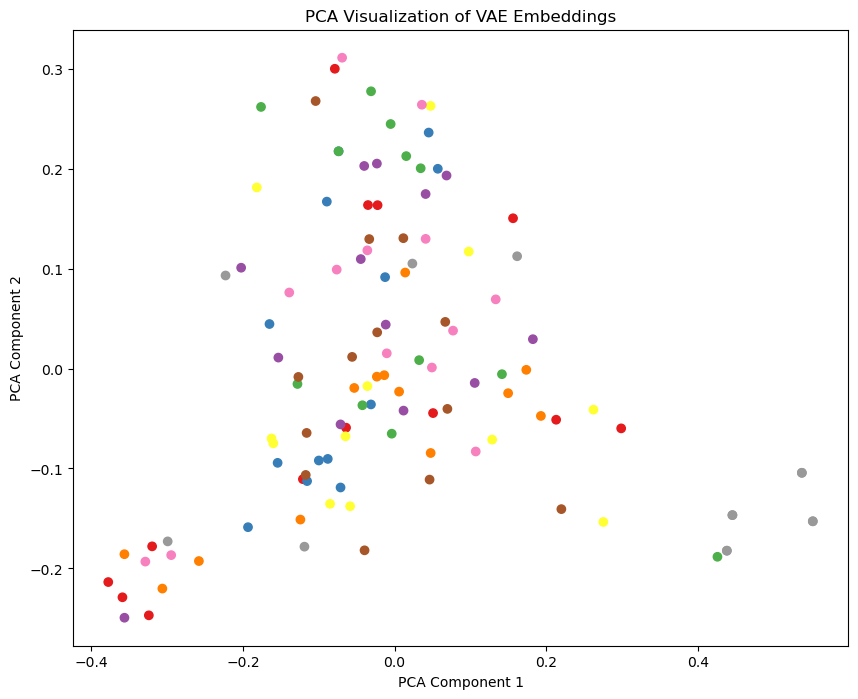

In [100]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(smiles_df['PC1'], smiles_df['PC2'], c=range(len(smiles_df)), cmap='Set1')

# Customize the plot
# plt.colorbar(scatter, label='Covalent')
plt.title("PCA Visualization of VAE Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Show the plot
plt.show()


In [114]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# Create a scatter plot
plt.figure(figsize=(100, 100))
scatter = plt.scatter(smiles_df['PC1'], smiles_df['PC2'], c=range(len(smiles_df)), cmap='Set1')

# Customize the plot
plt.title("PCA Visualization of VAE Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add the skeletal formulas as images next to data points
for index, row in smiles_df.iterrows():
    smiles = row['smiles']
    molecule = Chem.MolFromSmiles(smiles)
    
    if molecule is not None:
        img = Draw.MolToImage(molecule, size=(500, 500))
        
        img = img.convert("RGBA")  # Convert to RGBA format for transparency support
        img_data = img.getdata()
        
        # Set transparent pixels where the image is white
        new_img_data = []
        for item in img_data:
            if item[:3] == (255, 255, 255):
                new_img_data.append((255, 255, 255, 100))  # Transparent pixel
            else:
                new_img_data.append(item)
        img.putdata(new_img_data)

        imagebox = OffsetImage(img, zoom=0.5)

        ab = AnnotationBbox(imagebox, (row['PC1'], row['PC2']), frameon=False, pad=0)
        plt.gca().add_artist(ab)

plt.show()


In [75]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(smiles_df, x='TSNE1', y='TSNE2', color='Covalent', 
                 hover_data=['PDB code', 'Ligands'])

# Customize the plot layout
fig.update_layout(title="t-SNE Visualization of VAE Embeddings",
                  xaxis_title="t-SNE Component 1",
                  yaxis_title="t-SNE Component 2")

# Show the plot
fig.show()

In [85]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(smiles_df, x='PHATE1', y='PHATE2', color='Covalent', 
                 hover_data=['PDB code', 'Ligands'])

# Customize the plot layout
fig.update_layout(title="PHATE Visualization of VAE Embeddings",
                  xaxis_title="PHATE Component 1",
                  yaxis_title="PHATE Component 2")

# Show the plot
fig.show()

In [113]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# Create a scatter plot
plt.figure(figsize=(100, 100))
scatter = plt.scatter(smiles_df['PHATE1'], smiles_df['PHATE2'], c=range(len(smiles_df)), cmap='Set1')

# Customize the plot
plt.title("PHATE Visualization of VAE Embeddings")
plt.xlabel("PHATE Component 1")
plt.ylabel("PHATE Component 2")

# Add the skeletal formulas as images next to data points
for index, row in smiles_df.iterrows():
    smiles = row['smiles']
    molecule = Chem.MolFromSmiles(smiles)
    
    if molecule is not None:
        img = Draw.MolToImage(molecule, size=(500, 500))
        
        img = img.convert("RGBA")  # Convert to RGBA format for transparency support
        img_data = img.getdata()
        
        # Set transparent pixels where the image is white
        new_img_data = []
        for item in img_data:
            if item[:3] == (255, 255, 255):
                new_img_data.append((255, 255, 255, 100))  # Transparent pixel
            else:
                new_img_data.append(item)
        img.putdata(new_img_data)

        imagebox = OffsetImage(img, zoom=0.5)

        ab = AnnotationBbox(imagebox, (row['PHATE1'], row['PHATE2']), frameon=False, pad=0)
        plt.gca().add_artist(ab)

plt.show()


In [79]:
# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(smiles_df, x='PHATE1', y='PHATE2', z='PHATE3', color='Covalent', 
                    hover_data=['PDB', 'Ligands']
                    )

# Customize the plot layout
fig.update_layout(title="3D PHATE Visualization of VAE Embeddings",
                  scene=dict(xaxis_title="PHATE Component 1",
                             yaxis_title="PHATE Component 2",
                             zaxis_title="PHATE Component 3"))

# Show the plot
fig.show()
